In [63]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


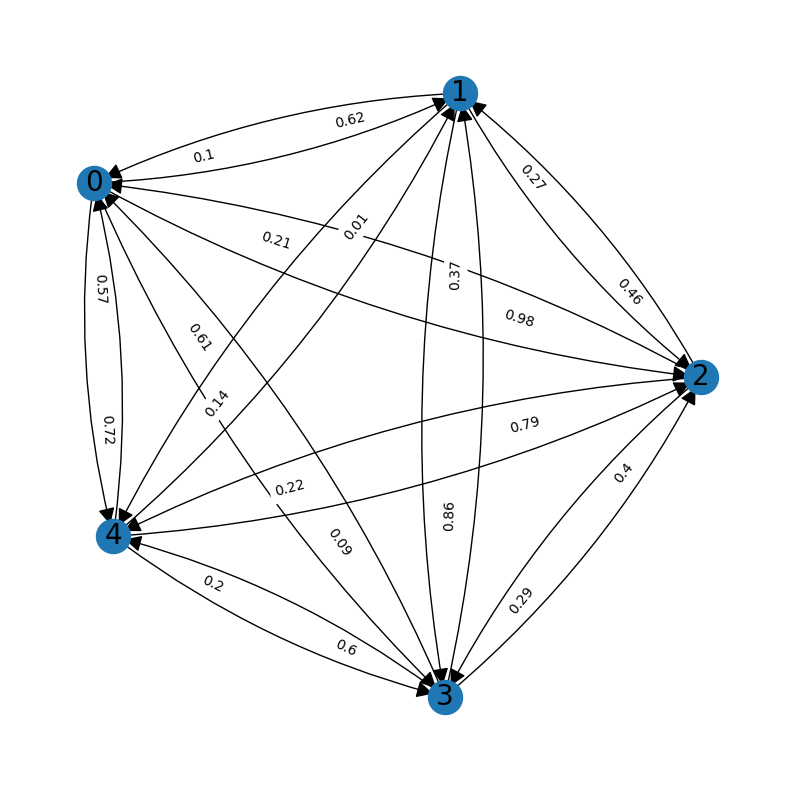

In [92]:
from Simulation import *
from Environment import *

click_probabilities = generate_click_probabilities(fully_connected=True)
observations_probabilities = generate_observation_probabilities(click_probabilities=click_probabilities)

concentration_params = [100] + [70] * NUM_OF_PRODUCTS
alpha_users = np.random.dirichlet(alpha= concentration_params, size = 1)

product_prices, users_reservation_prices = generate_prices(product_range=100, users_range=100)
tot_num_users = np.random.normal(loc=1000, scale=50)

env = Environment(users_reservation_prices = users_reservation_prices,
                    click_probabilities = click_probabilities,
                    observations_probabilities = observations_probabilities,
                    tot_num_users = tot_num_users)

Network.print_graph(G=env.network.G)

In [93]:
nodes_activation_probabilities = env.get_nodes_activation_probabilities(product_prices=product_prices)

In [94]:
B_cap = 100
budgets = np.linspace(start = 0, stop = B_cap, num = 11, endpoint = True)

In [95]:
from Ecommerce2 import *

In [96]:
ecomm2 = Ecommerce2(B_cap, budgets, product_prices, tot_num_users)

In [97]:
optimal_solution = ecomm2.solve_optimization_problem(env,nodes_activation_probabilities)

[[5.10130583e-05 1.08631990e-01 1.45576726e-01 1.45576726e-01
  1.45576726e-01 1.45576726e-01 1.45576726e-01 1.45576726e-01
  1.45576726e-01 1.45576726e-01 1.45576726e-01]
 [3.21499969e-04 6.96941675e-06 3.53976834e-02 1.12544067e-01
  1.70355744e-01 1.70355744e-01 1.70355744e-01 1.70355744e-01
  1.70355744e-01 1.70355744e-01 1.70355744e-01]
 [2.56781495e-06 1.04433621e-01 1.87907547e-01 1.87907547e-01
  1.87907547e-01 1.87907547e-01 1.87907547e-01 1.87907547e-01
  1.87907547e-01 1.87907547e-01 1.87907547e-01]
 [4.10079538e-04 8.96596569e-02 1.70931738e-01 1.83777711e-01
  1.83777711e-01 1.83777711e-01 1.83777711e-01 1.83777711e-01
  1.83777711e-01 1.83777711e-01 1.83777711e-01]
 [2.68338045e-04 1.48593042e-05 8.91551388e-05 4.72460785e-03
  3.77149807e-03 2.56570438e-02 3.65280646e-02 7.44076498e-02
  7.56220721e-02 1.47957021e-01 1.64160989e-01]]
optimal solution found is: [20. 40. 20. 20.  0.]


In [98]:
from Ecommerce3 import *
from Simulation import *
from Environment import *

In [99]:
ecomm3_ts = Ecommerce3_TS(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)
ecomm3_ucb = Ecommerce3_UCB(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)

In [1]:
gpucb_rewards_per_experiment = []
gpts_rewards_per_experiment = []
n_experiments = 10
T = 20

env = Environment(
    users_reservation_prices,
    click_probabilities,
    observations_probabilities,
    tot_num_users,
)
ecomm2 = Ecommerce2(B_cap, budgets, product_prices, tot_num_users)
optimal_allocation = ecomm2.solve_optimization_problem(env,nodes_activation_probabilities)

for e in tqdm(range(0, n_experiments), position=0, desc="n_experiment", leave=False):
    ecomm3_gpts = Ecommerce3_TS(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)
    nodes_activation_probabilities = env.get_nodes_activation_probabilities(product_prices)
    for t in tqdm(range(0, T), position=1, desc="n_iteration", leave=False):
        arm = ecomm3_gpts.pull_arm(nodes_activation_probabilities)
        reward = env.round_step3(arm)
        print(arm)
        print(reward)
        ecomm3_gpts.update(arm, reward)
    gpts_rewards_per_experiment.append(ecomm3_gpts.collected_rewards)



NameError: name 'Environment' is not defined

In [135]:
gpts_regret_superarm.shape

(10, 5)

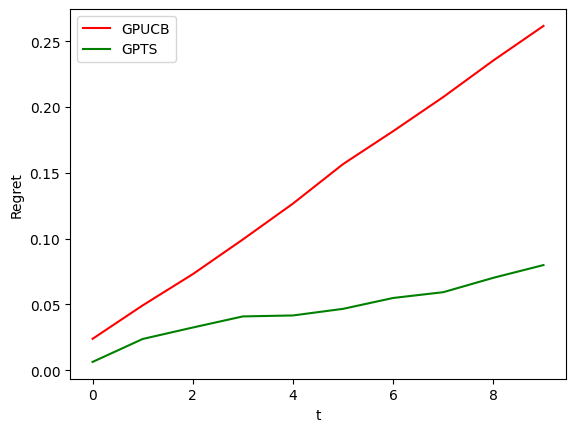

In [137]:
optimal_allocation = [20., 40.,20.,20. ,0.]
opt = env.round_step3(pulled_arm=optimal_allocation)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")

gpts_regret_superarm = opt - np.mean(np.array(gpucb_rewards_per_experiment), axis=2)
gpucb_regret_superarm = opt - np.mean(np.array(gpts_rewards_per_experiment), axis=2)


plt.plot(np.cumsum( np.mean(gpts_regret_superarm, axis=1)), "r")
plt.plot(np.cumsum(np.mean(gpucb_regret_superarm, axis=1)), "g")
plt.legend(["GPUCB", "GPTS"])
plt.show()

In [123]:
(opt - np.mean(np.array(gpucb_rewards_per_experiment), axis=2)).shape

(10, 5)

In [114]:
np.mean(np.array(gpts_rewards_per_experiment), axis=2).shape

(10, 5)

In [ ]:
from Environment import *
from Ecommerce3 import *

for _ in range(100):
    # print('------Thompson Sampling--------')
    # arms_values = ecomm3_ts.pull_arm(nodes_activation_probabilities)
    # print(arms_values)
    # reward = env.round_step3(pulled_arm=arms_values)
    # ecomm3_ts.update(pulled_arm = arms_values, reward = reward)

    print('------UCB--------')
    arms_values = ecomm3_ucb.pull_arm(nodes_activation_probabilities=nodes_activation_probabilities)
    print(arms_values)
    reward = env.round_step3(pulled_arm=arms_values)
    ecomm3_ucb.update(pulled_arm = arms_values, reward = reward)

In [20]:
ecomm3_ts.b

AttributeError: 'Ecommerce3_TS' object has no attribute 'b'

In [21]:
from Ecommerce5 import *

In [22]:
Ecommerce5.run_experiments(
    20,
    10,
    users_reservation_prices,
    click_probabilities,
    observations_probabilities,
    B_cap,
    budgets,
    product_prices,
    tot_num_users,
)


KeyboardInterrupt: 

In [86]:
ecomm5_gpts = Ecommerce5_GPTS(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)
ecomm5_ucb = Ecommerce5_UCB(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)